<a href="https://colab.research.google.com/github/Alx-a-cod/MLiterallyConfused/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
 # ==== file upload from PC ====
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes (1).csv


In [32]:
# ==== libraries import ====
import numpy as np
import pandas as pd
# ==== dependencies import ====
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns



In [33]:
# ==== load dataset ====

filename = "diabetes.csv"

df = pd.read_csv("diabetes.csv")

# ==== check both English (,) and European (;) separators ====
try:
    df = pd.read_csv(filename, sep=',')
    if df.shape[1] == 1: # if everything gets lumped in one column
        raise ValueError("Possible separator issue. Check your file and retry?")
except Exception:
    df = pd.read_csv(filename, sep=';')

# === dataset overview ===

print(f"Dataset loaded successfully: {filename}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("Columns:")
print(df.columns.tolist(), "\n")

print("Missing values per column:")
print(df.isna().sum(), "\n") # returns a DataFrame of booleans: True if it’s NaN, False if it’s a valid number or string

print("\nData types and non-null counts:")
df.info()

print("Preview:")
pd.set_option('display.max_columns', None)
df.head()

Dataset loaded successfully: diabetes.csv
Shape: 1199 rows × 9 columns

Columns:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] 

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64 


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               1199 non-null   int64  
 1   Glucose                   1199 non-null   int64  
 2   BloodPressure             1199 non-null   int64  
 3   SkinThickness             1199 non-null   int64  
 4   Insuli

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.63,50,1
1,1,85,66,29,0,26.6,0.35,31,0
2,8,183,64,0,0,23.3,0.67,32,1
3,1,89,66,23,94,28.1,0.17,21,0
4,0,137,40,35,168,43.1,2288.00,33,1


In [34]:
# ==== statistics & health-check about the Dataset ====

summary = df.describe().T
summary['missing'] = df.isna().sum()
summary['% missing'] = (df.isna().mean() * 100).round(1)
summary['dtype'] = df.dtypes
display(summary.round(2)) # display wrap for prettier dataframes: renders as clean HTML table in Colab instead of print text dump


,count,mean,std,min,25%,50%,75%,max,missing,% missing,dtype
Pregnancies,1199.0,4.62,3.11,0.00,2.0,4.00,7.00,17.0,0,0.0,int64
Glucose,1199.0,137.04,34.73,0.00,108.0,143.00,164.00,199.0,0,0.0,int64
BloodPressure,1199.0,73.96,17.62,0.00,68.0,76.00,84.50,122.0,0,0.0,int64
SkinThickness,1199.0,24.93,14.32,0.00,17.5,29.00,35.00,99.0,0,0.0,int64
Insulin,1199.0,87.53,100.99,0.00,0.0,82.00,140.00,846.0,0,0.0,int64
BMI,1199.0,33.13,6.99,0.00,29.7,33.10,37.45,67.1,0,0.0,float64
DiabetesPedigreeFunction,1199.0,52.54,265.24,0.08,0.3,0.62,0.72,2329.0,0,0.0,float64
Age,1199.0,40.10,14.01,21.00,26.5,41.00,51.00,81.0,0,0.0,int64
Outcome,1199.0,0.40,0.49,0.00,0.0,0.00,1.00,1.0,0,0.0,int64


Replaced 5 zeros in 'Glucose' → Missing: 0.42%
Replaced 35 zeros in 'BloodPressure' → Missing: 2.92%
Replaced 227 zeros in 'SkinThickness' → Missing: 18.93%
Replaced 493 zeros in 'Insulin' → Missing: 41.12%
Replaced 11 zeros in 'BMI' → Missing: 0.92%
Replaced 0 zeros in 'Age' → Missing: 0.00%

Missing values after zero replacement:


,Missing Values
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,493
BMI,11
Age,0



Data split shapes: Train: (839, 8), Val: (180, 8), Test: (180, 8)
Applied log1p transform to skewed features: ['Insulin', 'DiabetesPedigreeFunction']
Rows flagged as outliers in training set: 61 / 839

Outlier summary per feature:


,Feature,Outlier Count,Outlier %
6,DiabetesPedigreeFunction,27,3.218117
4,Insulin,22,2.622169
5,BMI,6,0.715137
2,BloodPressure,5,0.595948
0,Pregnancies,4,0.476758
3,SkinThickness,4,0.476758
1,Glucose,0,0.000000
7,Age,0,0.000000


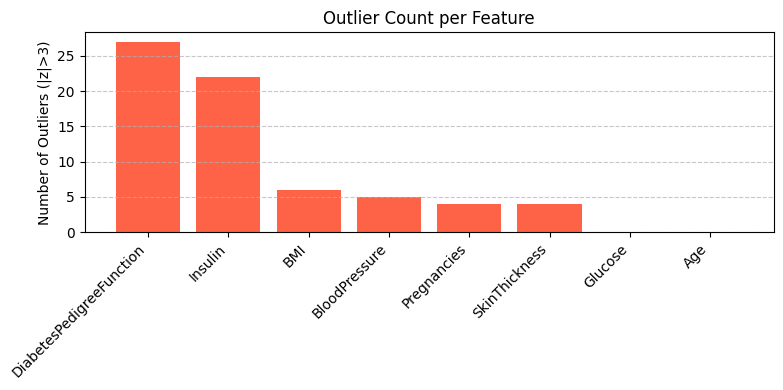

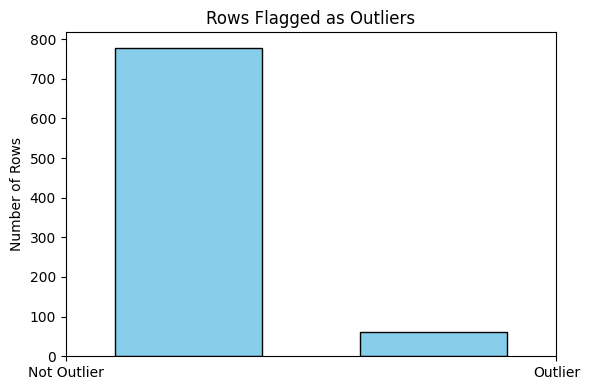

Features with >5% outliers removed: []
Shape after removing high-outlier features: (839, 8)

Preprocessing pipeline applied (median imputation + scaling).
Shape after preprocessing (train): (839, 8)

PCA Components (full matrix):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
PC1,0.371,0.427,0.408,0.348,0.255,0.363,0.016,0.442
PC2,-0.412,-0.078,-0.106,0.481,0.176,0.481,0.425,-0.373
PC3,0.035,0.179,0.027,-0.349,0.288,-0.317,0.805,0.113
PC4,-0.141,0.174,-0.284,-0.082,0.831,-0.111,-0.386,-0.097
PC5,0.687,-0.426,-0.511,0.217,0.127,0.038,0.142,0.027
PC6,0.149,-0.564,0.610,-0.305,0.306,0.201,-0.030,-0.244
PC7,0.173,0.311,-0.270,-0.590,-0.124,0.636,-0.003,-0.183



Explained variance by each PC:


,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,0.420,0.420
1,PC2,0.140,0.560
2,PC3,0.126,0.686
3,PC4,0.109,0.795
4,PC5,0.073,0.868
5,PC6,0.057,0.925
6,PC7,0.046,0.971


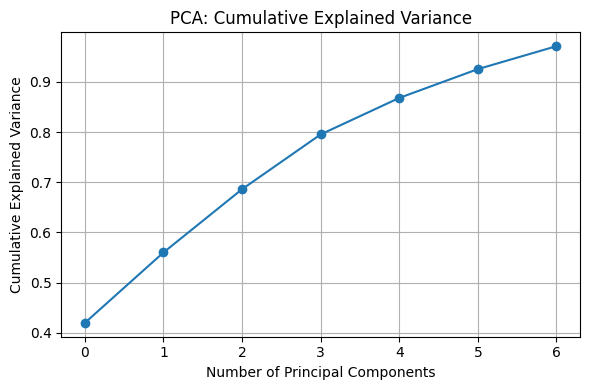


Any NaN after preprocessing? 0

Raw features (no PCA) shape: (839, 8)
PCA features shape: (839, 7)


In [44]:

# =========================
# DATA PREPROCESSING
# =========================

import numpy as np
import pandas as pd

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


# ==== 0. original copy to avoid overwriting ====

df_clean = df.copy()

# ==== 1. Replaced impossible zeros with NaN ====

target = "Outcome"
zeros_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "Age"]
log_transform = [] # e.g., ["Insulin"] if skewed <---- check diagnostics in the cells above

# --- SAFETY CHECK for missing expected columns
missing_cols = set(zeros_as_missing) - set(df_clean.columns)
if missing_cols:
    print("Warning! Columns expected for zero-replacement not found:", missing_cols)

# Replace zeros with NaN
if zeros_as_missing is not None:
    for col in zeros_as_missing:
        if col in df_clean.columns:
            missing_count = (df_clean[col] == 0).sum()
            df_clean[col] = df_clean[col].replace(0, np.nan)
            pct_missing = df_clean[col].isna().mean() * 100 #shows missing percentage
            print(f"Replaced {missing_count} zeros in '{col}' → Missing: {pct_missing:.2f}%")

    print("\nMissing values after zero replacement:")
    display(df_clean[zeros_as_missing].isna().sum().to_frame("Missing Values"))

# === 2. Splitting dataset before preprocessing to prevent leakage ===

X = df_clean.drop(target, axis=1)
y = df_clean[target]

# 1st split: train+val vs test
x_trainval, x_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 2nd split: train vs val (approx. 70/15/15)
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
)

print(f"\nData split shapes: Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

# ==== 3. Optional log-transform for skewed features ====

# Check skewness to decide which columns need log-transform
skewed_features = x_train.skew().abs()[x_train.skew().abs() > 1].index.tolist()

log_transform_flag = True  # Set to False to skip log-transform
if log_transform_flag and skewed_features:
    for col in skewed_features:
        x_train[col] = np.log1p(x_train[col])
        x_val[col] = np.log1p(x_val[col])
        x_test[col] = np.log1p(x_test[col])
    print("Applied log1p transform to skewed features:", skewed_features)

# ==== 4. Outlier detection on training data (before scaling, z-score method) ====
x_train_imputed = x_train.fillna(x_train.median())  # temporary for z-score
z_scores = np.abs(stats.zscore(x_train_imputed))

outliers = (z_scores > 3).any(axis=1) # Flag rows where any feature exceeds |z| > 3
print(f"Rows flagged as outliers in training set: {outliers.sum()} / {x_train.shape[0]}")

# Feature-level outlier counts
feature_outlier_counts = (z_scores > 3).sum(axis=0)
outlier_counts_df = pd.DataFrame({
    "Feature": x_train.columns,
    "Outlier Count": feature_outlier_counts,
    "Outlier %": feature_outlier_counts / x_train.shape[0] * 100
}).sort_values("Outlier %", ascending=False)

print("\nOutlier summary per feature:")
display(outlier_counts_df)

plt.figure(figsize=(8,4))
plt.bar(outlier_counts_df["Feature"], outlier_counts_df["Outlier Count"], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Outliers (|z|>3)")
plt.title("Outlier Count per Feature")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(outliers.astype(int), bins=2, rwidth=0.6, color='skyblue', edgecolor='black')
plt.xticks([0,1], ["Not Outlier", "Outlier"])
plt.ylabel("Number of Rows")
plt.title("Rows Flagged as Outliers")
plt.tight_layout()
plt.show()

# Decide what to remove
outlier_threshold = 5  # percentage threshold
features_to_remove = outlier_counts_df[outlier_counts_df["Outlier %"] > outlier_threshold]["Feature"].tolist()
print(f"Features with >{outlier_threshold}% outliers removed: {features_to_remove}")

# Drop features from all sets
x_train_clean = x_train.drop(columns=features_to_remove, errors='ignore')
x_val_clean   = x_val.drop(columns=features_to_remove, errors='ignore')
x_test_clean  = x_test.drop(columns=features_to_remove, errors='ignore')

print(f"Shape after removing high-outlier features: {x_train_clean.shape}")

# Keep labels unchanged
y_train_clean = y_train
y_val_clean   = y_val
y_test_clean  = y_test

# ==== 5. Preprocessing pipeline: median imputation + scaling ====
numeric_features = x_train_clean.columns.tolist()
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # handles NaN
    ("scaler", StandardScaler()),                   # zero mean, unit variance
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features)
], remainder="drop")

# Fit on clean train, transform validation and test
x_train_scaled = preprocessor.fit_transform(x_train_clean)
x_val_scaled = preprocessor.transform(x_val_clean)
x_test_scaled = preprocessor.transform(x_test_clean)

print("\nPreprocessing pipeline applied (median imputation + scaling).")
print("Shape after preprocessing (train):", x_train_scaled.shape)

# ==== 6. Generate BOTH versions: raw scaled and PCA scaled ====

# RAW PREPROCESSED (no PCA)
x_train_raw = x_train_scaled
x_val_raw = x_val_scaled
x_test_raw = x_test_scaled

# PCA PREPROCESSED
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

# OPTIONAL: show PCA diagnostics only if desired
apply_pca = True
if apply_pca:
    pca_components_df = pd.DataFrame(
        pca.components_,
        columns=numeric_features,
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    print("\nPCA Components (full matrix):")
    display(pca_components_df.round(3))

    explained_df = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(pca.n_components_)],
        "Explained Variance Ratio": np.round(pca.explained_variance_ratio_, 3),
        "Cumulative Variance": np.round(np.cumsum(pca.explained_variance_ratio_), 3)
    })
    print("\nExplained variance by each PC:")
    display(explained_df)

    plt.figure(figsize=(6,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Cumulative Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==== 7. Sanity checks ====
print("\nAny NaN after preprocessing?", np.isnan(x_train_pca).sum())
print("\nRaw features (no PCA) shape:", x_train_raw.shape)
print("PCA features shape:", x_train_pca.shape)


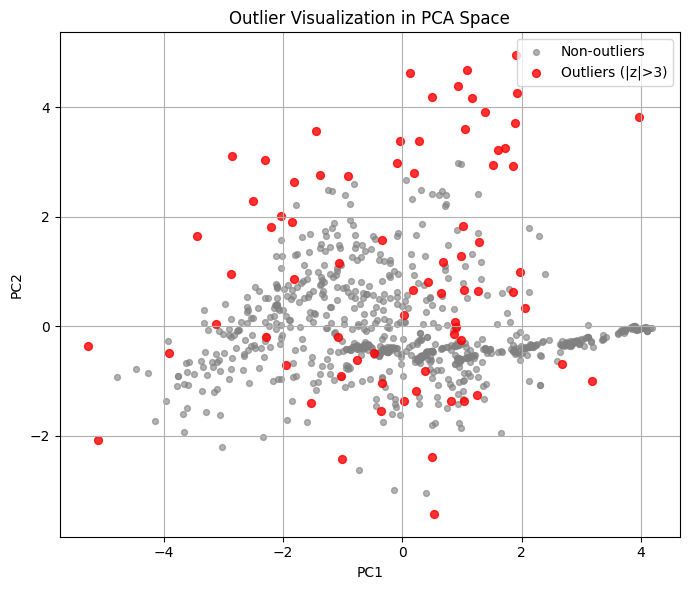

Example PCA-space outlier rows: [9, 16, 46, 64, 82, 108, 155, 159, 167, 189]


In [45]:
# =========================
# Optional: Visualize Outliers in PCA Space
# =========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if apply_pca:

    # DataFrame for PCA space
    X_train_pca_df = pd.DataFrame(
        x_train_pca,
        columns=[f"PC{i+1}" for i in range(x_train_pca.shape[1])]
    )

    # Labels after outlier removal
    y_arr = y_train_clean.values

    # Outlier mask in PCA space
    # We recalc Z-scores on the PCA-transformed training set
    z_pca = np.abs(stats.zscore(X_train_pca_df))
    outliers_pca = (z_pca > 3).any(axis=1)

    plt.figure(figsize=(7, 6))

    # Plot non-outliers
    plt.scatter(
        X_train_pca_df.loc[~outliers_pca, "PC1"],
        X_train_pca_df.loc[~outliers_pca, "PC2"],
        c="grey",
        alpha=0.6,
        s=18,
        label="Non-outliers"
    )

    # Plot PCA-space outliers in red
    plt.scatter(
        X_train_pca_df.loc[outliers_pca, "PC1"],
        X_train_pca_df.loc[outliers_pca, "PC2"],
        c="red",
        alpha=0.8,
        s=32,
        label="Outliers (|z|>3)"
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Outlier Visualization in PCA Space")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("PCA is disabled; skipping PCA-space outlier visualization.")

# Print example PCA-space outlier rows
outlier_indices_pca = X_train_pca_df[outliers_pca].index
print("Example PCA-space outlier rows:", outlier_indices_pca[:10].tolist())




=== GaussianNB === (using PCA features)

=== LogisticRegression === (using PCA features)
Best params: {'C': 0.1}

=== DecisionTree === (using Raw scaled features)
Best params: {'max_depth': 5}

=== RandomForest === (using Raw scaled features)
Best params: {'max_depth': 7, 'n_estimators': 50}

=== SVM === (using PCA features)
Best params: {'C': 1, 'kernel': 'rbf'}


,Model,Features,Train Accuracy,Val Accuracy,Test Accuracy,Train F1,Val F1,Test F1,Train ROC-AUC,Val ROC-AUC,Test ROC-AUC,Training Time (s),Fitted Model
2,DecisionTree,Raw,0.831,0.772,0.739,0.777,0.721,0.647,0.880,0.787,0.784,0.188,"DecisionTreeClassifier(max_depth=5, random_sta..."
3,RandomForest,Raw,0.881,0.728,0.767,0.843,0.662,0.682,0.954,0.806,0.837,6.063,"(DecisionTreeClassifier(max_depth=7, max_featu..."
4,SVM,PCA,0.802,0.722,0.778,0.728,0.638,0.697,0.858,0.761,0.821,3.162,"SVC(C=1, probability=True, random_state=42)"
1,LogisticRegression,PCA,0.771,0.706,0.789,0.691,0.619,0.708,0.828,0.748,0.828,0.153,"LogisticRegression(C=0.1, max_iter=1000)"
0,GaussianNB,PCA,0.749,0.711,0.722,0.632,0.594,0.621,0.809,0.716,0.787,0.002,GaussianNB()


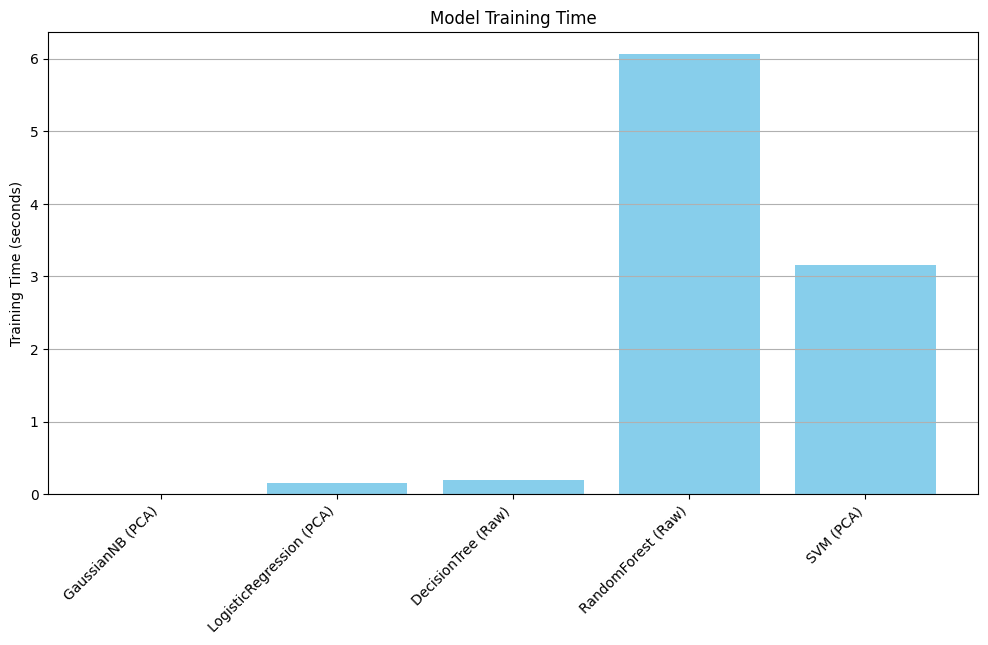

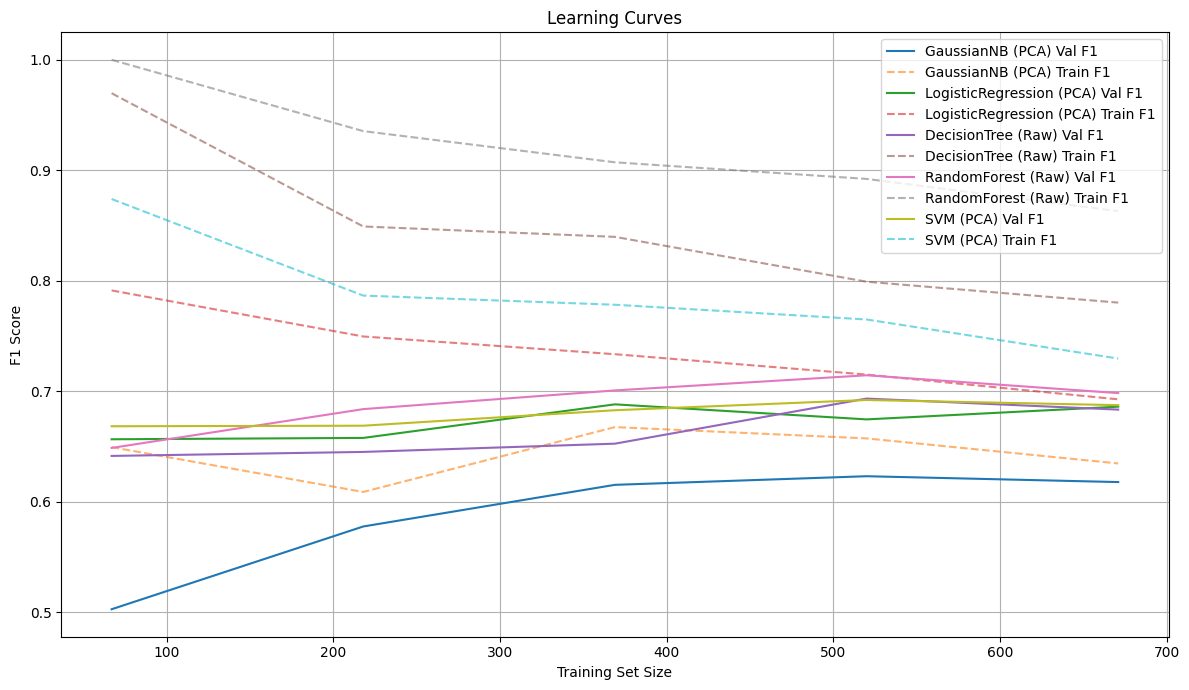


Confusion Matrix - GaussianNB (PCA) (Validation)
[[90 17]
 [35 38]]

Classification Report - GaussianNB (PCA) (Validation)
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       107
           1       0.69      0.52      0.59        73

    accuracy                           0.71       180
   macro avg       0.71      0.68      0.68       180
weighted avg       0.71      0.71      0.70       180


Confusion Matrix - LogisticRegression (PCA) (Validation)
[[84 23]
 [30 43]]

Classification Report - LogisticRegression (PCA) (Validation)
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       107
           1       0.65      0.59      0.62        73

    accuracy                           0.71       180
   macro avg       0.69      0.69      0.69       180
weighted avg       0.70      0.71      0.70       180


Confusion Matrix - DecisionTree (Raw) (Validation)
[[86 21]
 [20 53]]

Classifica

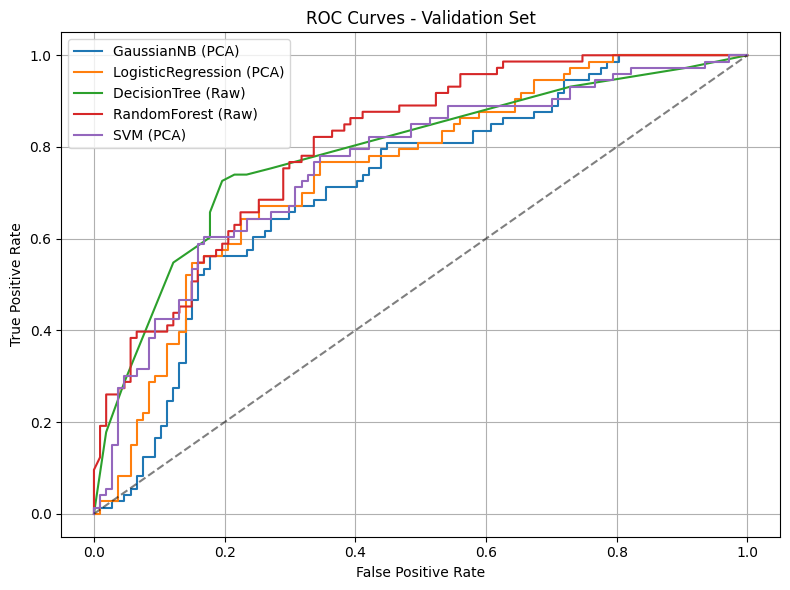

In [39]:
# =========================
# MODEL TRAINING: PCA vs Raw Features
# =========================

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone


from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)

# Model imports
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ---- Define models and optional hyperparameter grids ----
models = {
    "GaussianNB": (GaussianNB(), None),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {"max_depth": [3, 5, 7, None]}),
    "RandomForest": (RandomForestClassifier(random_state=42), {"n_estimators": [50, 100],"max_depth": [3, 5, 7, None]}),
    "SVM": (SVC(probability=True, random_state=42), {"C": [0.1, 1, 10],"kernel": ["linear", "rbf"]}),
}

# ---- Specify PCA vs Raw preference per model ----
# True = use PCA features, False = use raw scaled features
model_feature_pref = {
    "GaussianNB": True,
    "LogisticRegression": True,
    "DecisionTree": False,
    "RandomForest": False,
    "SVM": True,
}

# ---- Initialize results storage ----
results = []

# ---- Helper for probabilities (ROC-AUC) ----
def get_probs(mdl, X):
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:, 1]
    elif hasattr(mdl, "decision_function"):
        return mdl.decision_function(X)
    else:
        return None

# ---- Training loop ----
for name, (model, param_grid) in models.items():
    use_pca = model_feature_pref.get(name, True)
    X_tr = x_train_pca if use_pca else x_train_scaled
    X_val = x_val_pca if use_pca else x_val_scaled
    X_te = x_test_pca if use_pca else x_test_scaled

    print(f"\n=== {name} === (using {'PCA' if use_pca else 'Raw scaled'} features)")

    # Grid search if hyperparameters provided
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
        start_time = time.time()
        gs.fit(X_tr, y_train_clean)
        train_time = time.time() - start_time
        best_model = gs.best_estimator_
        print(f"Best params: {gs.best_params_}")
    else:
        start_time = time.time()
        model.fit(X_tr, y_train_clean)
        train_time = time.time() - start_time
        best_model = model

    # Clone and fit for evaluation
    model_fitted = clone(best_model)
    model_fitted.fit(X_tr, y_train_clean)

    # Use fitted model directly for evaluation <--- this is also good
    # model_fitted = best_model

    # Predictions
    y_train_pred = model_fitted.predict(X_tr)
    y_val_pred = model_fitted.predict(X_val)
    y_test_pred = model_fitted.predict(X_te)

    # Probabilities for ROC-AUC
    y_train_prob = get_probs(model_fitted, X_tr)
    y_val_prob = get_probs(model_fitted, X_val)
    y_test_prob = get_probs(model_fitted, X_te)

    # Metrics
    metrics = {
        "Model": name,
        "Features": "PCA" if use_pca else "Raw",
        "Train Accuracy": round(accuracy_score(y_train_clean, y_train_pred), 3),
        "Val Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
        "Test Accuracy": round(accuracy_score(y_test, y_test_pred), 3),
        "Train F1": round(f1_score(y_train_clean, y_train_pred), 3),
        "Val F1": round(f1_score(y_val, y_val_pred), 3),
        "Test F1": round(f1_score(y_test, y_test_pred), 3),
        "Train ROC-AUC": round(roc_auc_score(y_train_clean, y_train_prob), 3) if y_train_prob is not None else None,
        "Val ROC-AUC": round(roc_auc_score(y_val, y_val_prob), 3) if y_val_prob is not None else None,
        "Test ROC-AUC": round(roc_auc_score(y_test, y_test_prob), 3) if y_test_prob is not None else None,
        "Training Time (s)": round(train_time, 3),
        "Fitted Model": model_fitted
    }

    results.append(metrics)

# ---- Results DataFrame ----
results_df = pd.DataFrame(results)
display(results_df.sort_values(["Val F1", "Features"], ascending=[False, True]))

# ---- Training Time Plot ----
models_names = [f"{r['Model']} ({r['Features']})" for r in results]
training_times = [r["Training Time (s)"] for r in results]

plt.figure(figsize=(12, 6))
plt.bar(models_names, training_times, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ---- Learning Curves ----
plt.figure(figsize=(12, 7))
for r in results:
    name = f"{r['Model']} ({r['Features']})"
    model = clone(r["Fitted Model"])
    X_tr = x_train_pca if r['Features']=="PCA" else x_train_scaled
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_tr, y_train_clean, cv=5, scoring="f1",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.plot(train_sizes, val_scores.mean(axis=1), label=f"{name} Val F1")
    plt.plot(train_sizes, train_scores.mean(axis=1), linestyle='--', alpha=0.6, label=f"{name} Train F1")

plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Confusion Matrices (Validation) ----
for r in results:
    model = r["Fitted Model"]
    X_val = x_val_pca if r['Features']=="PCA" else x_val_scaled
    y_val_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"\nConfusion Matrix - {r['Model']} ({r['Features']}) (Validation)")
    print(cm)
    print(f"\nClassification Report - {r['Model']} ({r['Features']}) (Validation)")
    print(classification_report(y_val, y_val_pred))

# ---- Optional: ROC Curves for all models ----
plt.figure(figsize=(8,6))
for r in results:
    model = r["Fitted Model"]
    X_val = x_val_pca if r['Features']=="PCA" else x_val_scaled
    y_val_prob = get_probs(model, X_val)
    if y_val_prob is not None:
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        plt.plot(fpr, tpr, label=f"{r['Model']} ({r['Features']})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# ===== Final Summary Table =====
summary_cols = [
    "Model", "Features",
    "Train Accuracy", "Val Accuracy", "Test Accuracy",
    "Train F1", "Val F1", "Test F1",
    "Train ROC-AUC", "Val ROC-AUC", "Test ROC-AUC",
    "Training Time (s)"
]

# Sort by validation F1, then Features
summary_df = results_df[summary_cols].sort_values(["Val F1", "Features"], ascending=[False, True])
summary_df.reset_index(drop=True, inplace=True)

# Highlight overfitting: train F1 much higher than val F1
overfit_threshold = 0.1  # customize if you like
def highlight_overfit(row):
    return ['background-color: lightcoral' if (row['Train F1'] - row['Val F1']) > overfit_threshold else ''
            for _ in row]

# Display with styling
styled_summary = (summary_df.style
                  .format({
                      "Train Accuracy": "{:.3f}",
                      "Val Accuracy": "{:.3f}",
                      "Test Accuracy": "{:.3f}",
                      "Train F1": "{:.3f}",
                      "Val F1": "{:.3f}",
                      "Test F1": "{:.3f}",
                      "Train ROC-AUC": "{:.3f}",
                      "Val ROC-AUC": "{:.3f}",
                      "Test ROC-AUC": "{:.3f}",
                      "Training Time (s)": "{:.2f}"
                  })
                  .bar(subset=["Train F1", "Val F1", "Test F1"], color='lightgreen')
                  .bar(subset=["Val ROC-AUC", "Test ROC-AUC"], color='lightblue')
                  .apply(highlight_overfit, axis=1)
                 )

print("\n===== Model Performance Summary (PCA vs Raw Features) =====")
display(styled_summary)




===== Model Performance Summary (PCA vs Raw Features) =====


,Model,Features,Train Accuracy,Val Accuracy,Test Accuracy,Train F1,Val F1,Test F1,Train ROC-AUC,Val ROC-AUC,Test ROC-AUC,Training Time (s)
0,DecisionTree,Raw,0.831,0.772,0.739,0.777,0.721,0.647,0.880,0.787,0.784,0.19
1,RandomForest,Raw,0.881,0.728,0.767,0.843,0.662,0.682,0.954,0.806,0.837,6.06
2,SVM,PCA,0.802,0.722,0.778,0.728,0.638,0.697,0.858,0.761,0.821,3.16
3,LogisticRegression,PCA,0.771,0.706,0.789,0.691,0.619,0.708,0.828,0.748,0.828,0.15
4,GaussianNB,PCA,0.749,0.711,0.722,0.632,0.594,0.621,0.809,0.716,0.787,0.00


In [47]:
# ===== Best Models Summary =====

# Pick the best model per Features type based on Val F1
best_models_df = (results_df.groupby("Features")
                  .apply(lambda g: g.loc[g["Val F1"].idxmax()])
                  .reset_index(drop=True)
                 )

# Columns to show
best_cols = [
    "Model", "Features",
    "Train Accuracy", "Val Accuracy", "Test Accuracy",
    "Train F1", "Val F1", "Test F1",
    "Train ROC-AUC", "Val ROC-AUC", "Test ROC-AUC",
    "Training Time (s)"
]

# Display with same formatting
styled_best = (best_models_df[best_cols].style
               .format({
                   "Train Accuracy": "{:.3f}",
                   "Val Accuracy": "{:.3f}",
                   "Test Accuracy": "{:.3f}",
                   "Train F1": "{:.3f}",
                   "Val F1": "{:.3f}",
                   "Test F1": "{:.3f}",
                   "Train ROC-AUC": "{:.3f}",
                   "Val ROC-AUC": "{:.3f}",
                   "Test ROC-AUC": "{:.3f}",
                   "Training Time (s)": "{:.2f}"
               })
               .bar(subset=["Train F1", "Val F1", "Test F1"], color='lightgreen')
               .bar(subset=["Val ROC-AUC", "Test ROC-AUC"], color='lightblue')
              )

print("\n===== Best Models per Feature Type =====")
display(styled_best)



===== Best Models per Feature Type =====


/tmp/ipython-input-4067449232.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["Val F1"].idxmax()])


,Model,Features,Train Accuracy,Val Accuracy,Test Accuracy,Train F1,Val F1,Test F1,Train ROC-AUC,Val ROC-AUC,Test ROC-AUC,Training Time (s)
0,SVM,PCA,0.802,0.722,0.778,0.728,0.638,0.697,0.858,0.761,0.821,3.16
1,DecisionTree,Raw,0.831,0.772,0.739,0.777,0.721,0.647,0.880,0.787,0.784,0.19
